<a href="https://colab.research.google.com/github/yiyixuxu/denoising-diffusion-flax/blob/main/ddpm_flax_oxford102_end_to_end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising Diffusion Probabilistic Model in Flax

Demonstration notebook for
https://github.com/yiyixuxu/denoising-diffusion-flax

* this notebook is forked from [flax examples](https://github.com/google/flax/tree/main/examples)

The **DDPM-flax Notebook Workflow**:

1. Understand the different different configuration options  
  - This will open config files (`/configs/config_colab.py`) in the right-hand editor! you can edit your config file as you go through this section  
2. train a model from scratch and check out the outputs.
3. Generate beautiful flower samples from a pre-trained model!

## Setup

In [1]:
%%capture
! pip install clu
! pip install wandb
! pip install einops

In [23]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import jax
import jax.numpy as jnp
from ml_collections import config_dict
import tensorflow as tf
import tensorflow_datasets as tfds
from flax import jax_utils
from flax.training import checkpoints
from einops import rearrange, repeat
import numpy as np
import torch
from tqdm import tqdm, trange

In [3]:
import wandb
import math

In [4]:
import matplotlib.pyplot as plt 
from PIL import Image
import functools

### setup the ddpm-flax project and open the config file 

In [5]:
# if you have created a different config file, update the file path here,
# otherwise we will use the default config file oxford102_colab.py
# you can also open other files if you want to edit them e.g. train.py
editor_relpaths = ('configs/fashion_mnist.py',)

In [6]:
root_directory = 'denoising-diffusion-flax'
example_directory = 'denoising-diffusion-flax/denoising_diffusion_flax'
repo, branch =  'https://github.com/yiyixuxu/denoising-diffusion-flax', 'main'

In [7]:
# (If you run this code in Jupyter[lab], then you're already in the
#  example directory and nothing needs to be done.)

#@markdown
#@markdown **If you select no** below, then the files will be stored on the
#@markdown *ephemeral* Colab VM. **After some time of inactivity, this VM will
#@markdown be restarted an any changes are lost**.
#@markdown
#@markdown **If you select yes** below, then you will be asked for your
#@markdown credentials to mount your personal Google Drive. In this case, all
#@markdown changes you make will be *persisted*, and even if you re-run the
#@markdown Colab later on, the files will still be the same

if 'google.colab' in str(get_ipython()):
  import os
 
  mount_gdrive = 'yes' #@param ['yes', 'no']
  if mount_gdrive == 'yes':
    example_root_path = f'/content/gdrive/My Drive/{example_directory}'
    DISCLAIMER = 'Note : Editing in your Google Drive, changes will persist.'
    from google.colab import drive
    drive.mount('/content/gdrive/')
    os.chdir('/content/gdrive/My Drive')
    # Download ddpm-flax repo from Github.
    if not os.path.isdir(root_directory):
      !git clone -b $branch $repo
    os.chdir(example_root_path)
  else:
    DISCLAIMER = 'WARNING : Editing in VM - changes lost after reboot!!'
    example_root_path = f'/content/{example_directory}'
    os.chdir('/content/')
    if not os.path.isdir(root_directory):
      !git clone -b $branch $repo

    from IPython import display
    display.display(display.HTML(
        f'<h1 style="color:red;" class="blink">{DISCLAIMER}</h1>'))
    print(example_root_path)
    os.chdir(example_root_path)
  from google.colab import files
  for relpath in editor_relpaths:
    s = open(f'{example_root_path}/{relpath}').read()
    open(f'{example_root_path}/{relpath}', 'w').write(
        f'## {DISCLAIMER}\n' + '#' * (len(DISCLAIMER) + 3) + '\n\n' + s)
    files.view(f'{example_root_path}/{relpath}')

Mounted at /content/gdrive/
Cloning into 'denoising-diffusion-flax'...
remote: Enumerating objects: 271, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 271 (delta 13), reused 9 (delta 2), pack-reused 241
Receiving objects: 100% (271/271), 10.94 MiB | 20.74 MiB/s, done.
Resolving deltas: 100% (154/154), done.


<IPython.core.display.Javascript object>

In [7]:
# make sure you are in the ddmp-flax repo 
! pwd

/home/amawi/projects/denoising-diffusion-flax/denoising_diffusion_flax


### TPU setup

* If you wish to use TPU, please change your runtime type to TPU and check the box below 
  * Note that <font color=red>__TPU colab is NOT working correctly__ </font> at the moment, see issue here https://github.com/googlecolab/colabtools/issues/3009
  * *(I will remove this comment once the issue is resolved)*

* If you don't use TPU, please change your runtime type to GPU - don't use CPU to train the model!


In [8]:
# select tpu if you have it
# (it is not working correctly with colab at the moment)
use_tpu = False #@param {type:"boolean"}
if use_tpu:
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()



## import & helpers

In [9]:
# Local imports from current directory - auto reload.
# Any changes you make to train.py will appear automatically.
%load_ext autoreload
%autoreload 2

import train
import utils

In [10]:
def to_np(x):
  """Converts TF/JAX tensors to numpy."""
  return np.asarray(x, dtype=np.float32)

def to_wandb_img(img):
    img = rearrange(to_np(img), ' d b h w c -> (d b) c h w')
    if img.shape[1] == 1:
      img = repeat(img, 'b c h w -> b (repeat c) h w', repeat =3)
    return torch.tensor(img)

## Configure your training

This section include an overview of different config options 


#### load your config file

we will load `oxford102_colab.py` into our config `my_config`

In this section, feel free to edit the fields in your config dict `my_config` to see how it affect the training process ; 

only edit the the config file itself (`/configs/oxford102_colab`) when you want it to be used for training in next section

In [11]:
from configs import fashion_mnist as config_lib
my_config = config_lib.get_config()

### data

`data.dataset`

the script can run directly on any TensorFlow dataset, just set the configuration field `data.dataset` to the desired dataset name. 

You can find a list of ready-to-use dataset [here](tensorflow dataset name https://www.tensorflow.org/datasets/catalog/overview)

In [12]:
my_config.data.dataset

'fashion_mnist'

`data.batch_size`

if you are using TPU with `8` devices, make sure your `batch_size` can be divided by `8` 

In [13]:
my_config.data.batch_size

1024

`image_size` and `channels`

if your `data.image_size` is different than the actual image size, it will be automatically resized and may cause the images to look blurry; I recomend to use the actual size unless the images in your dataset do not have same sizes. 



In [14]:
my_config.data.image_size

28

In [15]:
rng = jax.random.PRNGKey(0)
train_it = train.get_dataset(rng, my_config)
img = next(train_it)['image']

2022-11-01 11:50:26.833901: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling fashion_mnist-train.tfrecord...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling fashion_mnist-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /home/amawi/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


our input image has 5 dimensions: `num_device`, `batch_size per device`, `Height`, `Width`, `channels`

take a look to make sure our input images have good quality

In [16]:
img.shape

(1, 1024, 28, 28, 1)

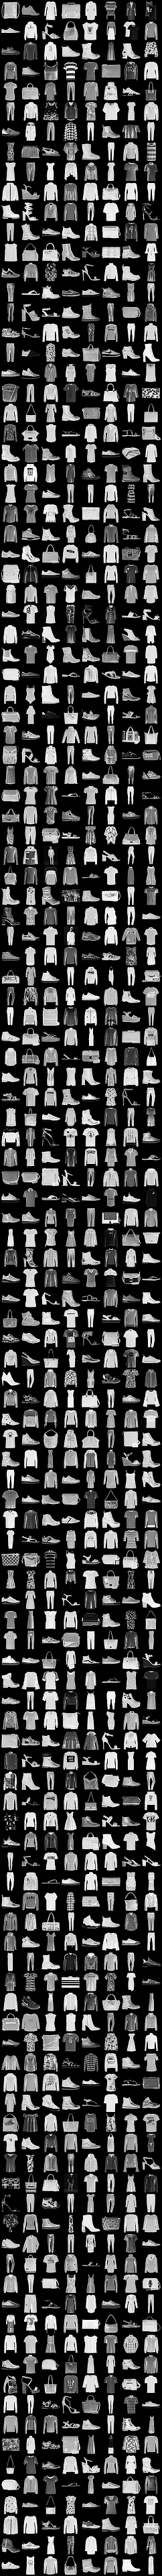

In [17]:
wandb.Image(to_wandb_img(img)).image

### wandb logging

I turned off wandb logging for this notebook, if you have an wandb, feel free to enable w&B logging by edit these options

In [18]:
my_config.wandb

entity: null
job_type: training
log_model: true
log_sample: true
log_train: true
name: null
project: ddpm-flax-fashion-mnist

### p2 weighting

__P2 (perception prioritized) weighting__ optimizes the weighting scheme of the training objective function to improve sample quality. It encourages the diffusion model to focus on recovering signals from __highly corrupted data__ (i.e. when noise level is higher), where the model learns global and perceptually rich concepts. 

You can read more about P2 weighting in the [paper](https://arxiv.org/abs/2204.00227) and check out the github [repo](https://github.com/jychoi118/P2-weighting)

You can apply it by change the values of p2 hyperparameters in config file:
* `config.ddpm.p2_loss_weight_gamma` 
* `config.ddpm.p2_loss_weight_k`; 

the paper recomend use `p2_loss_weight_gamma=1` and `p2_loss_weight_k=1`; In my own experience, using P2 weighting will train much faster and greatly improve sample quality



current value of p2 hyperparameters

In [19]:
my_config.ddpm.p2_loss_weight_gamma

0.0

In [20]:
my_config.ddpm.p2_loss_weight_k

1

when you change `p2_loss_weight_gamma` to `0` - every noise level gets same weight, so P2 weighting is not applied

In [21]:
my_config.ddpm.p2_loss_weight_gamma = 0

/home/amawi/.conda/envs/td/lib/python3.10/site-packages/jax/linear_util.py:168: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in linspace is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  ans = self.f(*args, **dict(self.params, **kwargs))
/home/amawi/.conda/envs/td/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2187: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  start = asarray(start, dtype=computation_dtype)
/home/amawi/.conda/envs/td/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2188: UserWarn

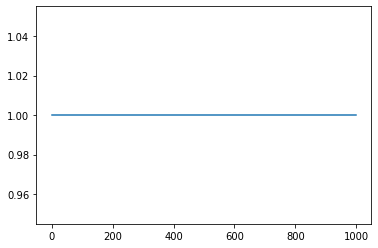

In [22]:
p2_weights = utils.get_ddpm_params(my_config.ddpm)['p2_loss_weight']
plt.plot(range(len(p2_weights)), p2_weights)

when you change `p2_loss_weight_gamma` to `1` - the more corrupted data will get higher weight when calculating the loss 

as you can see in below chart, p2 weight (y-axis) increase as the noise level/ timestep (x-axis) increases

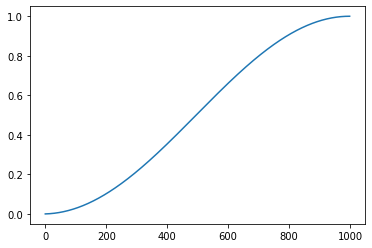

In [58]:
my_config.ddpm.p2_loss_weight_gamma = 1
p2_weights = utils.get_ddpm_params(my_config.ddpm)['p2_loss_weight']
plt.plot(range(len(p2_weights)),p2_weights)

### model EMA

we will keep track of an exponential moving average version of the model and use it to generate samples. You can find the list of hyperparameters with default values for ema calculation

* `inv_gamma` and `power` is used to calculate `ema_decay` rate for each training step
  * `ema_decay = (1 + steps / config.inv_gamma) ** - config.power `
* `min_value` and `beta` determine the minimum and maximum `ema_decay`
* `update_after_step` determines when to start average the model
*  `update_every` determines the how often we average the model 

In [24]:
my_config.ema

beta: 0.995
inv_gamma: 1.0
min_value: 0.0
power: 0.6666666666666666
update_after_step: 100
update_every: 10

change the `my_config.ema.inv_gamme` and `my_config.ema.power` to see how it affect `ema_decay` rate through out the training process 

In [25]:
ema_decay_fn = train.create_ema_decay_schedule(my_config.ema)

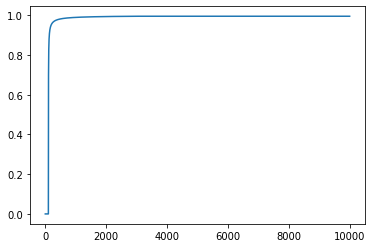

In [26]:
plt.plot(range(10000), [ema_decay_fn(t).item() for t in range(10000)])

we then use `ema_decay` to calculate the exponential moving average of model parameters at every `10` training steps ( when `ema.update_every=10`)

```parameter_ema = parameters * (1- ema_decay) + parameter_ema * ema_decay```

see `apply_ema_decay` function for more details

In [27]:
train.apply_ema_decay??

Signature: train.apply_ema_decay(state, ema_decay)
Docstring: <no docstring>
Source:   
def apply_ema_decay(state, ema_decay):
    params_ema = jax.tree_map(lambda p_ema, p: p_ema * ema_decay + p * (1. - ema_decay), state.params_ema, state.params)
    state = state.replace(params_ema = params_ema)
    return state
File:      ~/projects/denoising-diffusion-flax/denoising_diffusion_flax/train.py
Type:      function


### beta schedule

we currently provide 2 beta schedules: `cosine` or `linear`, if you pass any value other than these 2, you will get an exception

it determine the beta value at each timestep, which then determine all ddpm parameters 

linear schedule

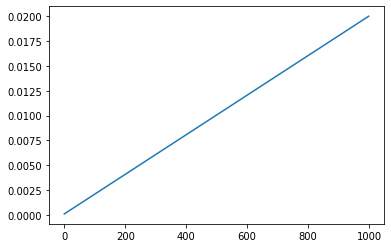

In [28]:
plt.plot(range(my_config.ddpm.timesteps), utils.linear_beta_schedule(my_config.ddpm.timesteps))

cosine schedule is proposed in this paper https://arxiv.org/abs/2102.09672

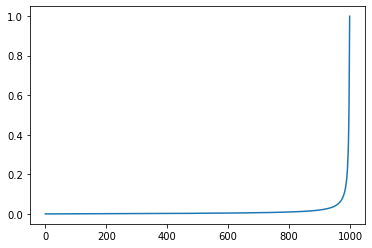

In [29]:
plt.plot(range(my_config.ddpm.timesteps), utils.cosine_beta_schedule(my_config.ddpm.timesteps))

### self_conditioning

Self-Conditioning is a useful technique for improving diffusion models. In a typical diffusion sampling process, the model iteratively predict `x0` in order to gradually denoise the image, and the `x0` estimated from previous step is discard in the new step; with self-conditioning, the model will also take previously generated samples as input.

You read more about the technique in the paper [Analog Bits: Generating Discrete Data using Diffusion Models with Self-Conditioning](https://arxiv.org/abs/2208.04202)

If you wish to apply self-conditioning, set `config.ddpm.self_condition=True`;

In [30]:
my_config.ddpm.self_condition

False

see __the implementation for self-condition__ in `model_predict` function

basically, if we choose to apply self-condition, at 50% of the training steps, we would run below additional process to get model prediction:
1. create a zero tensor with same shape as `x` and concatenate it together with `x` to create new model input 
2. put it through model to get predicted `x0` (if our model predict noise, and by default we do, we need to apply an additional step to estimate `x0` from predicted noise)
3. concatenate the predicted `x0` with `x` to create the input and put it through model again 


```python
# called by p_loss and ddpm_sample_step - both use pmap
def model_predict(state, x, x0, t, ddpm_params, self_condition, is_pred_x0, use_ema=True):
    if use_ema:
        variables = {'params': state.params_ema}
    else:
        variables = {'params': state.params}
    
    if self_condition:
        pred = state.apply_fn(variables, jnp.concatenate([x, x0],axis=-1), t)
    else:
        pred = state.apply_fn(variables, x, t)

    if is_pred_x0: # if the objective is is_pred_x0, pred == x0_pred
        x0_pred = pred
        noise_pred =  x0_to_noise(pred, x, t, ddpm_params)
    else:
        noise_pred = pred
        x0_pred = noise_to_x0(pred, x, t, ddpm_params)
    
    return x0_pred, noise_pred
```

That's pretty much it! all other other configuration options are pretty standard and self-explanatory

let me know if you have other questions, I will add to this section

## Training from scratch

once you've played around the options and decided your configurations, load the config file in again and update it before run the training code


in this example, I will use the `oxford102_colab` config file, we will apply p2 weighting but not self-conditioning;

I also turned off W&B logging, free free to turn it back on if you have an W&B account! 


In [31]:
from configs import fashion_mnist as config_lib
my_config = config_lib.get_config()

In [33]:
my_config

data:
  batch_size: 1024
  cache: false
  channels: 1
  dataset: fashion_mnist
  image_size: 28
ddpm:
  beta_schedule: linear
  p2_loss_weight_gamma: 0.0
  p2_loss_weight_k: 1
  pred_x0: false
  self_condition: false
  timesteps: 1000
ema:
  beta: 0.995
  inv_gamma: 1.0
  min_value: 0.0
  power: 0.6666666666666666
  update_after_step: 100
  update_every: 10
model:
  dim: 64
  dim_mults: !!python/tuple
  - 1
  - 2
  - 4
optim:
  beta1: 0.9
  beta2: 0.99
  eps: 1.0e-08
  lr: 0.001
  optimizer: Adam
seed: 42
training:
  half_precision: false
  log_every_steps: 100
  loss_type: l1
  num_sample: 64
  num_train_steps: 12000
  save_and_sample_every: 1000
wandb:
  entity: null
  job_type: training
  log_model: true
  log_sample: true
  log_train: true
  name: null
  project: ddpm-flax-fashion-mnist

It take 1 hour and 45 minutes to train 20k steps and the results are already looking pretty good at 20k - free free to train it longer or shorter by update `my_config.training.num_train_steps`

In [34]:
work_dir = './fashion_mnist'
state = train.train(my_config, work_dir)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chem-meme-squad (use `wandb login --relogin` to force relogin)


  0%|          | 0/12000 [00:00<?, ?it/s]2022-11-01 12:11:07.965404: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module pmap__unnamed_wrapped_function_] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-11-01 12:17:18.760719: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 8m10.79524857s

********************************
[Compiling module pmap__unnamed_wrapped_function_] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
  0%|          | 3/12000 [13:48<722:57:44, 216.94s/it] 

### take a look at the generated samples! (from the latest checkpoint)

In [ ]:
pwd

'/content/denoising-diffusion-flax/denoising_diffusion_flax'

In [15]:
sample_dir = work_dir + '/samples'
os.listdir(sample_dir)

['iter_4999_host_0',
 'iter_9999_host_0',
 'iter_14999_host_0',
 'iter_19999_host_0']

In [16]:
# find the most recent generated samples
iter_last = max([int(f.split('_')[1]) for f in os.listdir(sample_dir)])
sample_path = sample_dir + '/iter_' + str(iter_last) +  '_host_0/sample.png'
sample_path

'./flower102/samples/iter_19999_host_0/sample.png'

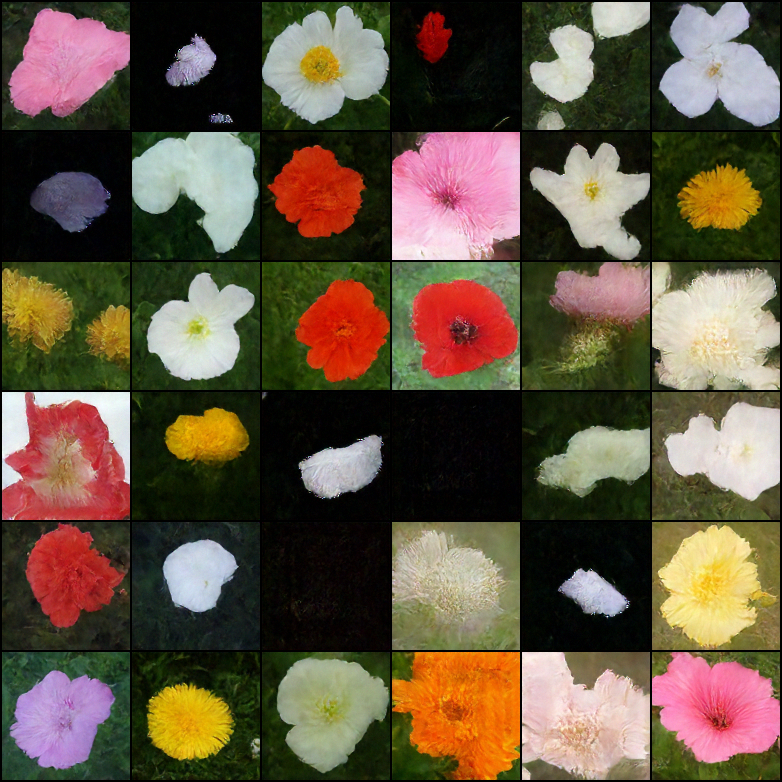

In [17]:
Image.open(sample_path)

## sampling from a pre-trained model 

the pre-trained model we are using is trained with both self-conditioning and p2 weighting for 300k steps 


In [26]:
from sampling import sample_loop, ddpm_sample_step, model_predict
from configs import oxford102_p2_selfcondition

In [34]:
# feel free to choose a different seed
sample_seed = 0
num_sample = 64
wandb_artifact = 'yiyixu/ddpm-flax-flower102/model-38gwgt6w:v0'
sample_bs = 16 # 

In [35]:
cfg = oxford102_p2_selfcondition.get_config()

In [36]:
shape = (jax.device_count(), 
         sample_bs, 
         cfg.data.image_size, 
         cfg.data.image_size, 
         cfg.data.channels)
shape

(1, 16, 128, 128, 3)

In [37]:
rng = jax.random.PRNGKey(sample_seed)
rng, state_rng = jax.random.split(rng)

state = train.create_train_state(state_rng, cfg)
run = wandb.init()
artifact = run.use_artifact('yiyixu/ddpm-flax-flower102/model-38gwgt6w:v0', type='ddpm_model')
artifact_dir = artifact.download()

state = checkpoints.restore_checkpoint(artifact_dir, state)
state = jax_utils.replicate(state)

ddpm_params = utils.get_ddpm_params(cfg.ddpm)

sample_step = functools.partial(ddpm_sample_step, ddpm_params=ddpm_params, self_condition=cfg.ddpm.self_condition, is_pred_x0=cfg.ddpm.pred_x0)
p_sample_step = jax.pmap(sample_step, axis_name='batch')



wandb: Downloading large artifact model-38gwgt6w:v0, 553.34MB. 1 files... Done. 0:0:1.9


generating samples


100%|██████████| 1/1 [00:46<00:00, 46.65s/it]


In [41]:
print("generating samples")
samples = []
for i in trange(0, num_sample, sample_bs):
  rng, sample_rng = jax.random.split(rng)
  samples.append(sample_loop(sample_rng, state, shape, p_sample_step, cfg.ddpm.timesteps))

samples = jnp.concatenate(samples) # num_devices, batch, H, W, C
          

generating samples


100%|██████████| 4/4 [02:27<00:00, 36.93s/it]


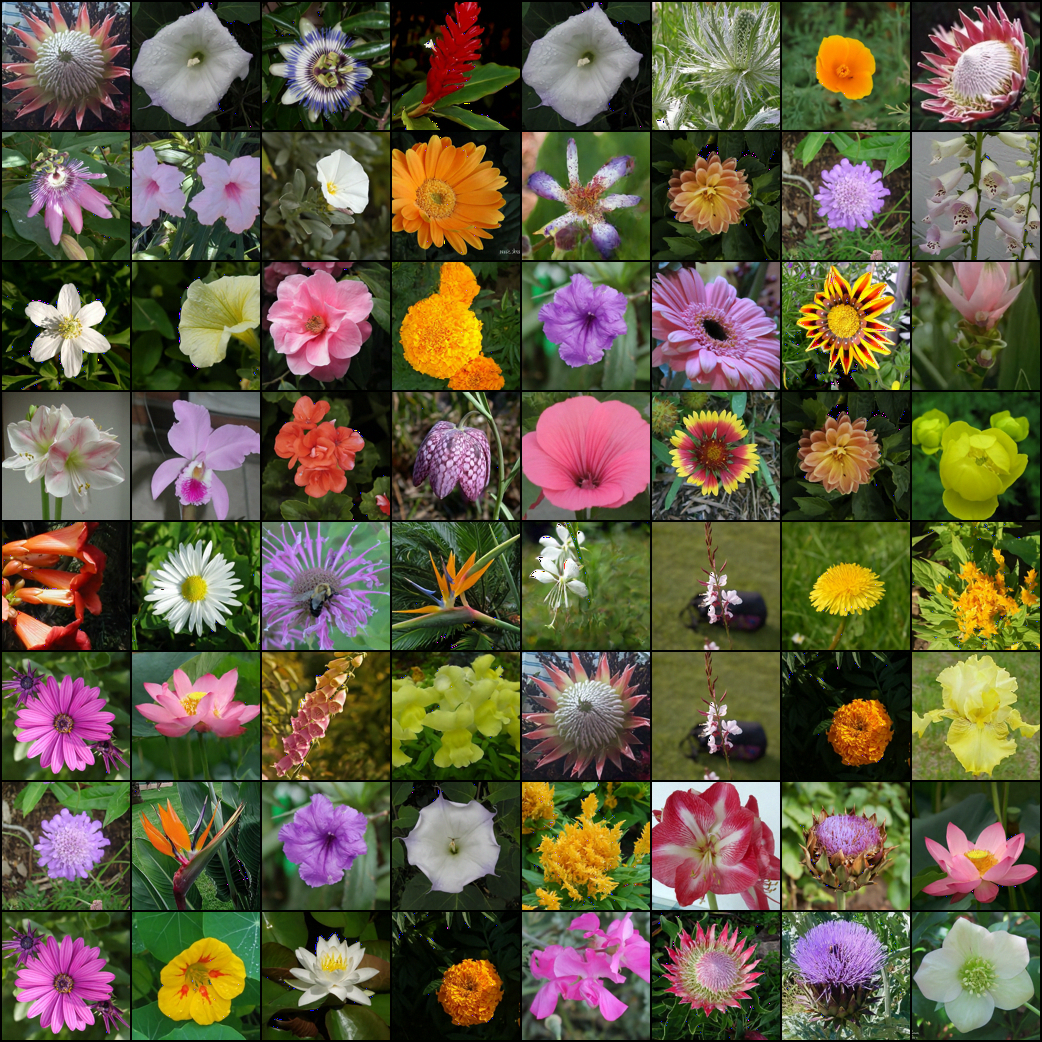

In [42]:
wandb.Image(to_wandb_img(samples)).image